In [1]:
import xarray as xr
from matplotlib import pyplot as plt
from cartopy import crs as ccrs
from cartopy import feature as cfeat
from metpy.plots import USCOUNTIES
import numpy as np
from os import listdir, path
from datetime import datetime as dt, timedelta

import pyart
from cmweather.cm_colorblind import ChaseSpectral, plasmidis, turbone
from cmocean.cm import phase

from pyxlma import coords
from glmtools.io.lightning_ellipse import lightning_ellipse_rev
from scipy.interpolate import griddata

ltg_ell = lightning_ellipse_rev[1]


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [2]:
tfm = xr.open_dataset('/Volumes/LtgSSD/tobac_saves/tobac_Save_20220602/seabreeze-obs.zarr', engine='zarr')

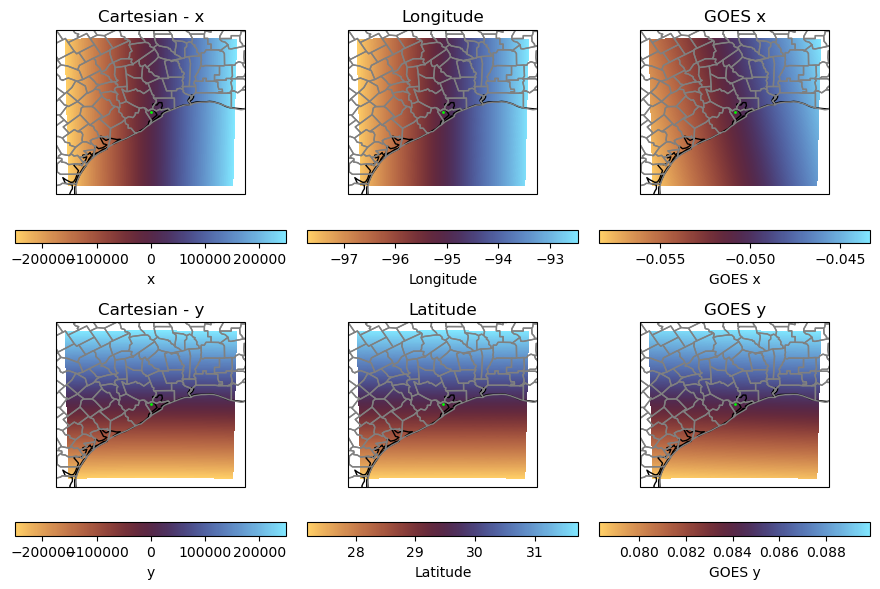

In [3]:
# Coords testing plots
ax_extent = [tfm.lon.min()-0.25, tfm.lon.max()+0.25, tfm.lat.min()-0.25, tfm.lat.max()+0.25]
x2d, y2d = np.meshgrid(tfm.x.data, tfm.y.data)
fig, axs = plt.subplots(2, 3, subplot_kw={'projection': ccrs.PlateCarree()})
cartx = axs[0, 0].pcolormesh(tfm.lon, tfm.lat, x2d, transform=ccrs.PlateCarree(), cmap='managua')
axs[0, 0].set_title('Cartesian - x')
fig.colorbar(cartx, ax=axs[0, 0], orientation='horizontal', label='x')
carty = axs[1, 0].pcolormesh(tfm.lon, tfm.lat, y2d, transform=ccrs.PlateCarree(), cmap='managua')
axs[1, 0].set_title('Cartesian - y')
fig.colorbar(carty, ax=axs[1, 0], orientation='horizontal', label='y')


geolon = axs[0, 1].pcolormesh(tfm.lon, tfm.lat, tfm.lon, transform=ccrs.PlateCarree(), cmap='managua')
axs[0, 1].set_title('Longitude')
fig.colorbar(geolon, ax=axs[0, 1], orientation='horizontal', label='Longitude')
geolat = axs[1, 1].pcolormesh(tfm.lon, tfm.lat, tfm.lat, transform=ccrs.PlateCarree(), cmap='managua')
axs[1, 1].set_title('Latitude')
fig.colorbar(geolat, ax=axs[1, 1], orientation='horizontal', label='Latitude')

goesx = axs[0, 2].pcolormesh(tfm.lon, tfm.lat, tfm.g16_scan_x, transform=ccrs.PlateCarree(), cmap='managua')
axs[0, 2].set_title('GOES x')
fig.colorbar(goesx, ax=axs[0, 2], orientation='horizontal', label='GOES x')
goesy = axs[1, 2].pcolormesh(tfm.lon, tfm.lat, tfm.g16_scan_y, transform=ccrs.PlateCarree(), cmap='managua')
axs[1, 2].set_title('GOES y')
fig.colorbar(goesy, ax=axs[1, 2], orientation='horizontal', label='GOES y')


for i in range(2):
    for j in range(3):
        ax = axs[i, j]
        ax.add_feature(cfeat.COASTLINE.with_scale('50m'))
        ax.add_feature(cfeat.BORDERS.with_scale('50m'))
        ax.add_feature(USCOUNTIES.with_scale('20m'), edgecolor='gray')
        ax.set_extent(ax_extent)
        ax.scatter(tfm.center_lon, tfm.center_lat, transform=ccrs.PlateCarree(), color='lime', s=1)

px = 1/plt.rcParams['figure.dpi']  # pixel in inches
fig.set_size_inches(900*px, 600*px)
fig.tight_layout()

In [4]:
# Timeseries testing plots
tobac_data = tfm.copy()
tobac_save_path = f'/Volumes/LtgSSD/tobac_saves/tobac_Save_{date_i_want.strftime('%Y%m%d')}/'
for f in listdir(tobac_save_path):
    if f.startswith('timeseries_data_melt') and f.endswith('.nc'):
        tobac_timeseries_path = path.join(tobac_save_path, f)
        break
else:
    raise ValueError('>>>>>>>Unable to find timeseries data...>>>>>>>')
timeseries_data = xr.open_dataset(tobac_timeseries_path, chunks='auto')
timeseries_data = timeseries_data.reindex(feature=tobac_data.feature.data, fill_value=np.nan)
for dv in timeseries_data.data_vars:
    if dv not in tobac_data.data_vars:
        tobac_data[dv] = timeseries_data[dv].copy()

NameError: name 'date_i_want' is not defined

NameError: name 'date_i_want' is not defined

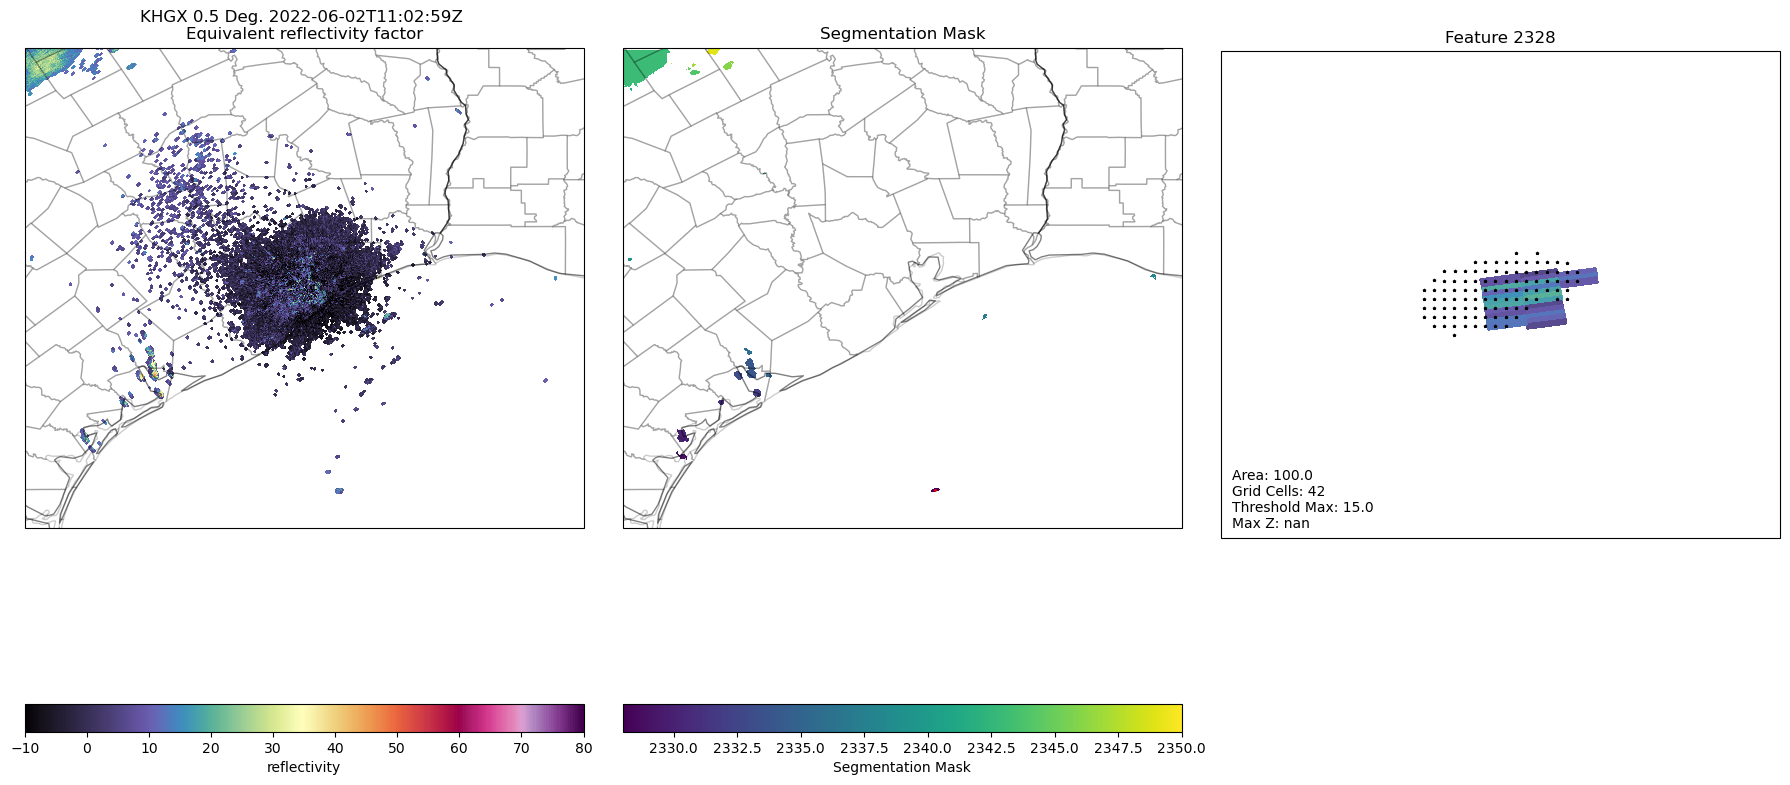

In [ ]:
for feat_time_index, radar_time in enumerate(tobac_data.time.data.astype('datetime64[s]').astype('O')):
    radar_filepath = f'/Volumes/LtgSSd/nexrad_l2/{radar_time.strftime('%Y%m%d')}/KHGX{radar_time.strftime("%Y%m%d_%H%M%S")}_V06'
    if not path.exists(radar_filepath):
        continue
    rdr = pyart.io.read(radar_filepath)
    tfm_time = tfm.isel(time=feat_time_index)
    tfm_time = tfm_time.isel(feature=(tfm_time.feature_time_index == feat_time_index))
    axis_limits = [tfm_time.lon.min(), tfm_time.lon.max(), tfm_time.lat.min(), tfm_time.lat.max()]
    for feat_id in tfm_time.feature.data:
        tfm_feat_time = tfm_time.sel(feature=feat_id)
        for tfmvar in ['z', 'zdr', 'rhvdeficit', 'kdp']:
            if tfmvar == 'z':
                radarvar = 'reflectivity'
                cmap = ChaseSpectral
                vmin = -10
                vmax = 80
                text_str = f'Area: {tfm_feat_time.feature_area.data.item():.1f}\n' \
                        f'Grid Cells: {tfm_feat_time.feature_grid_cell_count.data}\n' \
                        f'Threshold Max: {tfm_feat_time.feature_threshold_max.data}\n' \
                        f'Max Z: {tfm_feat_time.feature_maxrefl.data}'
            else:
                if tfmvar == 'zdr':
                    radarvar = 'differential_reflectivity'
                    cmap = turbone
                    vmin = -2
                    vmax = 8
                elif tfmvar == 'rhvdeficit':
                    radarvar = 'cross_correlation_ratio'
                    cmap = plasmidis
                    vmin = 0
                    vmax = 1
                elif tfmvar == 'kdp':
                    radarvar = 'differential_phase'
                    cmap = phase
                    vmin = 0
                    vmax = 360
                text_str = f'{tfmvar}vol: {tfm_feat_time[f"feature_{tfmvar}vol"].data}\n' \
                        f'{tfmvar}col: {tfm_feat_time[f"feature_{tfmvar}col"].data}\n' \
                        f'{tfmvar}col_mean: {tfm_feat_time[f"feature_{tfmvar}col_mean"].data:.1f}\n' \
                        f'{tfmvar}col_total: {tfm_feat_time[f"feature_{tfmvar}col_total"].data}\n' \
                        f'{tfmvar}zdrwt_total: {tfm_feat_time.feature_zdrwt_total.data}\n'
            fig, axs = plt.subplots(1, 3, subplot_kw={'projection': ccrs.PlateCarree()})
            fig.set_size_inches(1800*px, 1200*px)
            rmd = pyart.graph.RadarMapDisplay(rdr)
            rmd.plot_ppi_map(radarvar, sweep=0, vmin=vmin, vmax=vmax, cmap=cmap, colorbar_label=radarvar, embellish=False, lat_lines=[], lon_lines=[], ax=axs[0], fig=fig, colorbar_orient='horizontal', zorder=2)
            seg_handle = axs[1].pcolormesh(tfm_feat_time.lon, tfm_feat_time.lat, tfm_feat_time.segmentation_mask, transform=ccrs.PlateCarree(), cmap='viridis', zorder=2)
            fig.colorbar(seg_handle, ax=axs[1], orientation='horizontal', label='Segmentation Mask')
            axs[1].scatter(tfm_feat_time.feature_lon, tfm_feat_time.feature_lat, transform=ccrs.PlateCarree(), color='red', s=1, zorder=3)
            axs[1].set_title('Segmentation Mask')
            
            segmask_trans = tfm_feat_time.segmentation_mask#.transpose(*tfm_feat_time.lon.dims) # TODO: FIX FROM ISSUE #7
            feat_grid_lons = tfm_feat_time.lon.data.flatten()[segmask_trans.data.flatten() == feat_id]
            feat_grid_lats = tfm_feat_time.lat.data.flatten()[segmask_trans.data.flatten() == feat_id]

            rmd.plot_ppi_map(radarvar, sweep=0, vmin=vmin, vmax=vmax, cmap=cmap, colorbar_label=radarvar, embellish=False, lat_lines=[], lon_lines=[], ax=axs[2], fig=fig, colorbar_flag=False, zorder=2)
            axs[2].scatter(feat_grid_lons, feat_grid_lats, transform=ccrs.PlateCarree(), color='gold', marker='*', edgecolors='black', s=3, zorder=3)
            axs[2].set_extent([feat_grid_lons.min()-0.1, feat_grid_lons.max()+0.1, feat_grid_lats.min()-0.1, feat_grid_lats.max()+0.1], crs=ccrs.PlateCarree())
            axs[2].set_title(f'Feature {feat_id}')
            axs[2].text(0.02, 0.02, text_str, transform=axs[2].transAxes)
            for i, ax in enumerate(axs):
                ax.add_feature(cfeat.STATES.with_scale('50m'), zorder=4, alpha=0.5)
                ax.add_feature(USCOUNTIES.with_scale('5m'), zorder=4, alpha=0.2)
                if i != 2:
                    ax.set_extent(axis_limits, crs=ccrs.PlateCarree())

            fig.tight_layout()
            fig.savefig(f'./debug-figs-{date_i_want.strftime("%Y%m%d")}/tobac_ts/{tfmvar}_{feat_id}.png')
            plt.close(fig)
            break
        break
    break

In [ ]:
# EET testing plots
def find_eet_feature(tfm, radar_path, time_idx, should_debug=True):
    axis_limits = [tfm.lon.min(), tfm.lon.max(), tfm.lat.min(), tfm.lat.max()]
    feature_indicies_at_time = np.nonzero(tfm.feature_time_index.compute().data == time_idx)[0]
    radar = xr.open_dataset(radar_path, engine='zarr').isel(time=0, nradar=0)
    this_eet = radar.eet_sam.data
    vmax = np.nanmax(this_eet)
    vmin = np.nanmin(this_eet)
    features_at_time = tfm.isel(feature=feature_indicies_at_time, time=time_idx)
    feature_eet = np.full(features_at_time.feature.data.shape, np.nan)
    if should_debug:
        px = 1/plt.rcParams['figure.dpi']
        fig, axs = plt.subplots(1, 3, subplot_kw={'projection': ccrs.PlateCarree()})
        fig.set_size_inches(1800*px, 1200*px)
        wide_eet_handle = axs[0].pcolormesh(features_at_time.lon, features_at_time.lat, this_eet, transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax)
        wide_seg_handle = axs[1].pcolormesh(features_at_time.lon, features_at_time.lat, features_at_time.segmentation_mask, transform=ccrs.PlateCarree())
        zoom_eet_bkgd = axs[2].pcolormesh(features_at_time.lon, features_at_time.lat, this_eet, alpha=0.5, transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax)
        fig.colorbar(wide_eet_handle, ax=axs[0], orientation='horizontal', label='Echo Top Height')
        fig.colorbar(wide_seg_handle, ax=axs[1], orientation='horizontal', label='Segmentation Mask')
        axs[0].set_title('Echo Tops')
        axs[1].set_title('Segmentation Mask')
    for j, feat_to_find in enumerate(features_at_time.feature.data):
        this_seg_mask = features_at_time.segmentation_mask.data
        if not np.any(this_seg_mask == feat_to_find):
            continue
        feature_eet[j] = np.nanmax(this_eet[this_seg_mask == feat_to_find])
        if should_debug:
            feature_ctr_scatter = axs[1].scatter(features_at_time.feature_lon.data[j], features_at_time.feature_lat.data[j], color='red', s=1, transform=ccrs.PlateCarree())
            
            feat_grid_lons = tfm_feat_time.lon.data.flatten()[this_seg_mask.flatten() == feat_to_find]
            feat_grid_lats = tfm_feat_time.lat.data.flatten()[this_seg_mask.flatten() == feat_to_find]
            feat_grid_eet = this_eet[this_seg_mask == feat_to_find]
            feature_grid_scatter = axs[2].scatter(feat_grid_lons, feat_grid_lats, c=feat_grid_eet, edgecolors='black', s=10, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree())
            feature_target_scatter = axs[2].scatter(
                feat_grid_lons[np.nanargmax(feat_grid_eet)],
                feat_grid_lats[np.nanargmax(feat_grid_eet)],
                c='#00000000', edgecolors='red', s=50, transform=ccrs.PlateCarree()
            )
            axs[2].set_extent([feat_grid_lons.min()-0.1, feat_grid_lons.max()+0.1, feat_grid_lats.min()-0.1, feat_grid_lats.max()+0.1], crs=ccrs.PlateCarree())
            axs[2].set_title(f'Feature {feat_to_find}')
            for i, ax in enumerate(axs):
                ax.add_feature(cfeat.STATES.with_scale('50m'), zorder=4, alpha=0.5)
                ax.add_feature(USCOUNTIES.with_scale('5m'), zorder=4, alpha=0.2)
                if i != 2:
                    ax.set_extent(axis_limits, crs=ccrs.PlateCarree())
            fig.tight_layout()
            fig.savefig(f'./debug-figs-{date_i_want.strftime("%Y%m%d")}/eet/{feat_to_find}.png')
            feature_ctr_scatter.remove()
            feature_grid_scatter.remove()
            feature_target_scatter.remove()
        break
    if should_debug:
        plt.close(fig)
    start_idx = feature_indicies_at_time[0]
    end_idx = feature_indicies_at_time[-1] + 1
    radar.close()
    return feature_eet, start_idx, end_idx

NameError: name 'date_i_want' is not defined

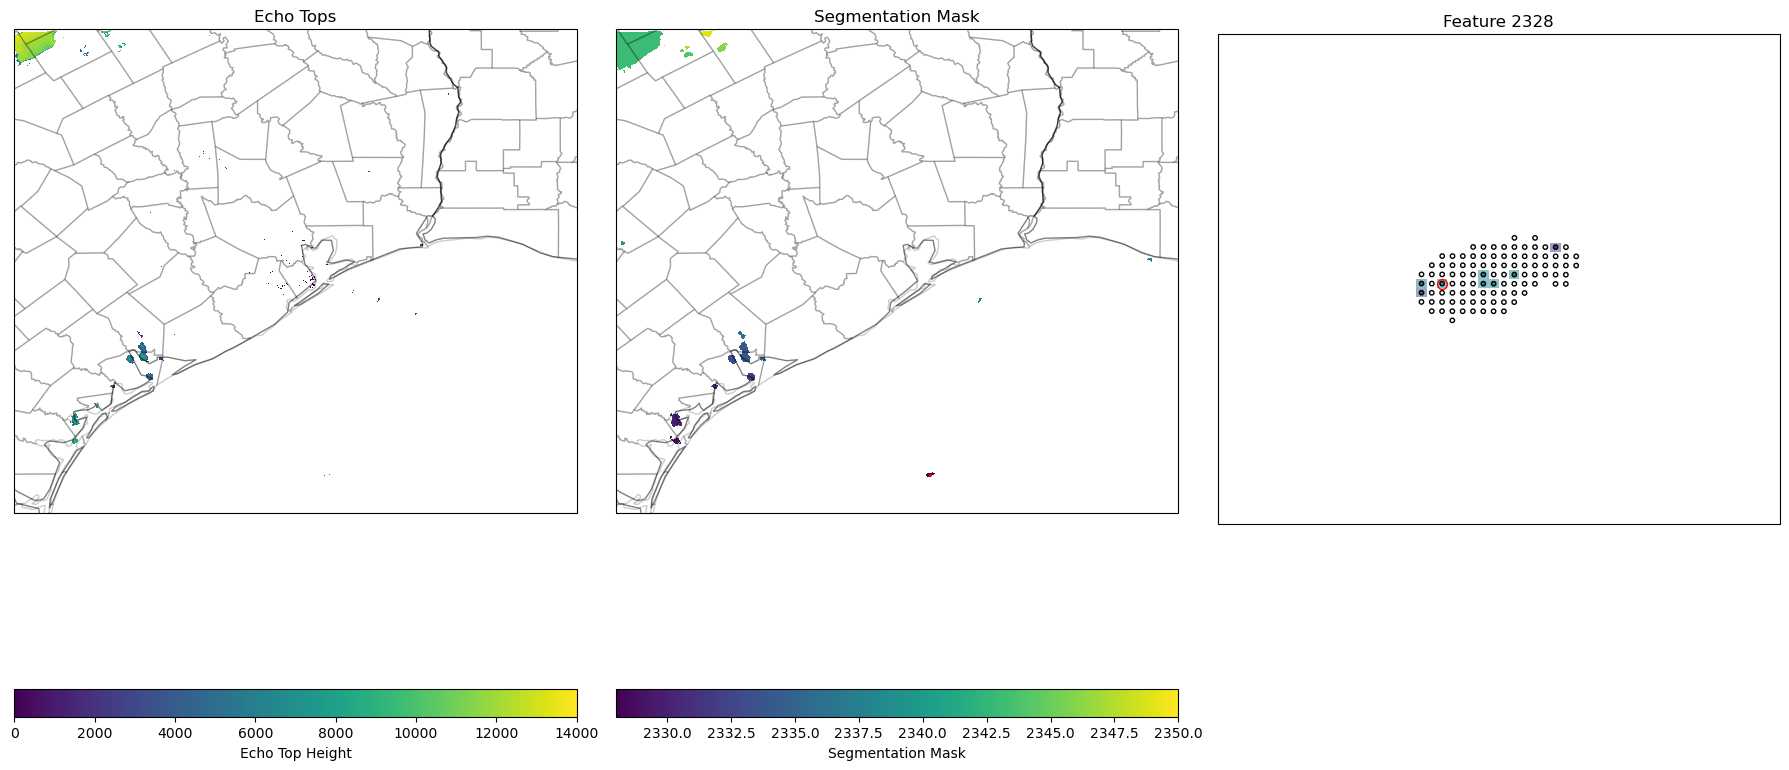

In [ ]:
_ = find_eet_feature(tfm, '/Volumes/LtgSSD/nexrad_zarr/JUNE/20220602/KHGX20220602_110259_V06_grid.zarr', 107)

In [ ]:
goes_max_x = tfm.g16_scan_x.max().data.item()
goes_min_x = tfm.g16_scan_x.min().data.item()
goes_max_y = tfm.g16_scan_y.max().data.item()
goes_min_y = tfm.g16_scan_y.min().data.item()
padding = .001
goes_xsclice = slice(goes_min_x-padding, goes_max_x+padding)
goes_yslice = slice(goes_max_y+padding, goes_min_y-padding)
# CTT testing plots
def prepare_find_satellite(this_feature_time_idx, should_debug=False):
    time = tfm.time.data.astype('datetime64[s]').astype('O')[this_feature_time_idx]
    feature_indicies_at_time = np.nonzero(tfm.feature_time_index.data == this_feature_time_idx)[0]
    if len(feature_indicies_at_time) == 0:
        return 0, 0, 0
    tfm_time = tfm.isel(feature=feature_indicies_at_time, time=this_feature_time_idx)
    this_timestep_sat_temps = np.full(tfm_time.feature.shape[0], np.nan)
    # if this_feature_time_idx not in download_results['tobac_idx'].values:
    #     return np.nan, 0, 0
    # goes_file_path = download_results[download_results['tobac_idx'] == this_feature_time_idx]['file'].values[0]
    goes_file_path = '/Volumes/LtgSSD/noaa-goes16/ABI-L2-MCMIPC/2022/153/11/OR_ABI-L2-MCMIPC-M6_G16_s20221531101174_e20221531103547_c20221531104063.nc'
    goes_file_path = path.join('/Volumes/LtgSSD/', goes_file_path)
    satellite_data = xr.open_dataset(goes_file_path).sel(y=goes_yslice, x=goes_xsclice)
    sat_y2d, sat_x2d = np.meshgrid(satellite_data.y.data, satellite_data.x.data)
    sat_z2d = np.zeros_like(sat_x2d)
    satsys = coords.GeostationaryFixedGridSystem(subsat_lon=satellite_data.nominal_satellite_subpoint_lon.data.item(), sweep_axis='x')

    satellite_ECEF = satsys.toECEF(sat_x2d.flatten(), sat_y2d.flatten(), sat_z2d.flatten())
    tpcs = coords.TangentPlaneCartesianSystem(ctrLat=tfm_time.center_lat, ctrLon=tfm_time.center_lon, ctrAlt=0)
    sat_TPCS_x, sat_TPCS_y, sat_TPCS_z = tpcs.fromECEF(*satellite_ECEF)
    sat_TPCS_x = sat_TPCS_x.reshape(sat_x2d.shape)
    sat_TPCS_y = sat_TPCS_y.reshape(sat_x2d.shape)
    sat_TPCS_z = sat_TPCS_z.reshape(sat_x2d.shape)
    if should_debug:
        fig = plt.figure()
        axs = []
        axs.append(fig.add_subplot(1, 3, 1))
        axs.append(fig.add_subplot(1, 3, 2))
        axs.append(fig.add_subplot(1, 3, 3))
        px = 1/plt.rcParams['figure.dpi']
        fig.set_size_inches(900*px, 300*px)

        axs[0].pcolormesh(satellite_data.x, satellite_data.y, satellite_data.CMI_C02, cmap='Grays_r')
        axs[0].pcolormesh(tfm.g16_scan_x, tfm.g16_scan_y, tfm_time.segmentation_mask.data, cmap='viridis')
        axs[1].pcolormesh(sat_TPCS_x, sat_TPCS_y, satellite_data.CMI_C02.transpose('x', 'y'), cmap='Grays_r')
        axs[1].pcolormesh(tfm.x, tfm.y, tfm_time.segmentation_mask.data, cmap='viridis')
        axs[1].set_xlim(tfm.x.min(), tfm.x.max())
        axs[1].set_ylim(tfm.y.min(), tfm.y.max())
        radar_filepath = f'/Volumes/LtgSSd/nexrad_l2/{time.strftime('%Y%m%d')}/KHGX{time.strftime("%Y%m%d_%H%M%S")}_V06'
        if path.exists(radar_filepath):
            radar = pyart.io.read(radar_filepath)
        else:
            radar = None
        if radar is not None:
            rmd = pyart.graph.RadarDisplay(radar)
            rmd.plot_ppi('reflectivity', sweep=0, vmin=-10, vmax=80, cmap='ChaseSpectral', colorbar_flag=False, ax=axs[2], fig=fig, zorder=10, alpha=0.5)
            axs[2].pcolormesh(sat_TPCS_x/1000, sat_TPCS_y/1000, satellite_data.CMI_C02.transpose('x', 'y'), cmap='Grays_r')
            axs[2].set_xlim(tfm.x.min()/1000, tfm.x.max()/1000)
            axs[2].set_ylim(tfm.y.min()/1000, tfm.y.max()/1000)
            axs[2].set_xlabel('')
            axs[2].set_ylabel('')
            axs[2].set_title('')
        fig.tight_layout()
        fig.savefig(f'./debug-figs-{date_i_want.strftime("%Y%m%d")}/ctt/transform-{this_feature_time_idx}.png')
        plt.close(fig)
    for j, feat_id in enumerate(tfm_time.feature.data):
        this_feat = tfm_time.sel(feature=feat_id)
        this_seg_mask = tfm_time.segmentation_mask.data
        
        feat_echotop = this_feat.feature_echotop.data.item()
        this_feature_time_idx = this_feat.feature_time_index.data.item()
        if np.isnan(feat_echotop):
            feat_echotop = 7e3
        satsys = coords.GeostationaryFixedGridSystem(subsat_lon=satellite_data.nominal_satellite_subpoint_lon.data.item(), sweep_axis='x',
                                                        ellipse=(ltg_ell[0] - 14e3 + feat_echotop, ltg_ell[1] - 6e3 + feat_echotop))
        satellite_ECEF = satsys.toECEF(sat_x2d.flatten(), sat_y2d.flatten(), sat_z2d.flatten())
        tpcs = coords.TangentPlaneCartesianSystem(ctrLat=tfm_time.center_lat, ctrLon=tfm_time.center_lon, ctrAlt=0)
        this_sat_TPCS_x, this_sat_TPCS_y, this_sat_TPCS_z = tpcs.fromECEF(*satellite_ECEF)
        this_sat_TPCS_x = this_sat_TPCS_x.reshape(sat_x2d.shape)
        this_sat_TPCS_y = this_sat_TPCS_y.reshape(sat_x2d.shape)
        this_sat_TPCS_z = this_sat_TPCS_z.reshape(sat_x2d.shape)
        tfm_x2d, tfm_y2d = np.meshgrid(tfm.x.data, tfm.y.data)
        
        sat_temps_regridded = griddata(
            np.array([this_sat_TPCS_x.flatten(), this_sat_TPCS_y.flatten()]).T,
            satellite_data.CMI_C13.transpose('x', 'y').data.flatten(),
            np.array([tfm_x2d.flatten(), tfm_y2d.flatten()]).T,
        ).reshape(tfm_x2d.shape)
        
        feat_grid_ctt = sat_temps_regridded[this_seg_mask == feat_id]
        min_sat_in_grid = np.nanmin(feat_grid_ctt)
        this_timestep_sat_temps[j] = min_sat_in_grid

        
    satellite_data.close()
    start_idx = feature_indicies_at_time[0]
    end_idx = feature_indicies_at_time[-1] + 1
    return this_timestep_sat_temps, start_idx, end_idx

tfm_time = tfm.isel(time=107)




In [ ]:
# Seabreeze testing plots
def make_sbf_plot(time_idx):
    tfm_time = tfm.isel(time=time_idx)
    time = tfm_time.time.data.astype('datetime64[s]').astype('O').item()
    tfm_feat_mask = (tfm_time.feature_time_index == time_idx)
    tfm_feat_time = tfm_time.isel(feature=tfm_feat_mask)
    fig = plt.figure()
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.pcolormesh(tfm_feat_time.lon, tfm_feat_time.lat, tfm_feat_time.seabreeze.transpose(*tfm_feat_time.lon.dims), transform=ccrs.PlateCarree(), zorder=1, alpha=0.25, cmap='RdBu')
    ax.pcolormesh(tfm_feat_time.lon, tfm_feat_time.lat, tfm_feat_time.segmentation_mask, transform=ccrs.PlateCarree(), zorder=2, cmap='Greys', vmin=0, vmax=1, alpha=0.5)
    ax.scatter(tfm_feat_time.feature_lon, tfm_feat_time.feature_lat, c=tfm_feat_time.feature_seabreeze, transform=ccrs.PlateCarree(), zorder=3, s=2, cmap='RdBu')
    ax.set_title(f'Features + Area + Seabreeze\n{time.strftime("%Y-%m-%d %H:%M:%S")}')
    ax.add_feature(cfeat.STATES.with_scale('50m'))
    ax.add_feature(USCOUNTIES.with_scale('5m'))
    fig.savefig(f'./debug-figs-{time.strftime("%Y%m%d")}/seabreeze/{time_idx}.png')


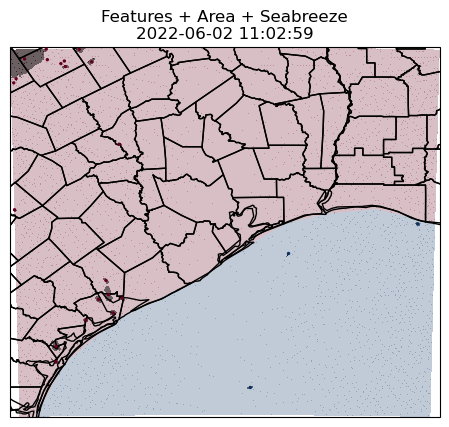

In [ ]:
make_sbf_plot(107)

In [8]:
tfm2.feature[np.argsort(tfm2.feature_area.data)].data[:100]

array([   1, 2094, 2121, 2148, 2155, 2161, 2169, 2186, 2213, 2230,  328,
       2231,  324,  323, 2284, 2288, 2313, 2315, 2316, 2363,  313, 2366,
       2373,  310, 2079,  306, 2076, 2050, 1655, 1669, 1672, 1674, 1677,
        385, 1681, 1721, 1789, 1803,  375, 1836, 1901, 1947, 1963, 1974,
       2001, 2003,  360, 2010,  356, 2047, 2048, 2071, 2444,  304,  303,
       2820,  255,  253,  252, 2887,  250,  248, 2907,  245,  244, 2916,
       2924,  241,  240,  239, 2967, 2996, 3002, 3084, 3092,  225, 3101,
       3112, 2806,  263, 2802,  265,  302, 2452,  299, 2496,  293,  292,
       2514, 2560, 2581, 2592, 2625, 1650, 2645, 2663, 2680, 2686, 2706,
       2717])

In [15]:
tfm2.time.data[221]

np.datetime64('2022-06-16T20:08:14.358000000')